# **Mental Health**

![image](image.jpg)

## 1) Business Understanding
---------------------------------------------------
### Introduction

Mental health conditions include mental disorders and psychosocial disabilities as well as other mental states associated with significant distress, impairment in functioning, or risk of self-harm. According to the World Health Organization (WHO), in 2019, 970 million people globally were living with a mental disorder, with anxiety and depression being the most common. Mental health conditions can cause difficulties in all aspects of life, including relationships with family, friends, and community. They can result from or lead to problems at school and at work. Globally, mental disorders account for 1 in 6 years lived with disability. People with severe mental health conditions die 10 to 20 years earlier than the general population. And having a mental health condition increases the risk of suicide and experiencing human rights violations. The economic consequences of mental health conditions are also enormous, with productivity losses significantly outstripping the direct costs of care.

## Problem Statement
-------------------------------------------------------

The increasing prevalence of mental health issues necessitates the development of effective tools to detect and address these conditions early. Using Natural Language Processing (NLP) and machine learning, we aim to analyze text data to identify indicators of mental health issues, thereby aiding in early detection and intervention.

## Objectives
-------------------------------------------------------
### Main Objective:
To develop a machine learning model that utilizes NLP techniques to detect mental health issues from text data.

### Specific Objectives:

- To preprocess and clean the text data for accurate analysis.
- To extract relevant features from the text data using NLP techniques.
- To train and evaluate various machine learning models to determine the best approach for detecting mental health issues.
- To validate the model using a separate dataset to ensure its effectiveness and generalizability.
- To deploy the model for practical use in identifying mental health issues from new text data.

## Metrics of Success
---------------------------------------------------------------------

 The performance of the model is evaluated based on achieving an accuracy of over 85%.


## Stakeholders
------------------------------------------------------------

- Researchers: Interested in the development and validation of models for detecting mental health issues.
- Mental Health Professionals: Looking for tools to assist in early detection and intervention of mental health conditions.
- Healthcare Providers: Aiming to improve patient outcomes by integrating advanced detection tools into their practice.
- Patients and the General Public: Benefiting from early detection and intervention, which can lead to better mental health management and support.
- Policy Makers: Utilizing the insights from the model to inform mental health policies and resource allocation.

## 2) Data Understanding
----------------------------------------------------------
The data used in this project was obtained from: [Kaggle](https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus).

The dataset has 1 csv: mental_health.csv and the file contains  27,977 rows and 2 columns.
text: object (contains the text data)
label: int64 (contains the labels indicating whether the text is poisonous or not):

- Non-Poisonous (0)',
- 'Poisonous (1)



### Import Libraries

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



from warnings import filterwarnings
filterwarnings(action='ignore')


### Loading the dataset


In [26]:
df = pd.read_csv('mental_health.csv')
df.head(10)

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1
5,hey rredflag sure right place post this goes ...,1
6,feel like someone needs hear tonight feeling r...,0
7,deserve liveif died right noone would carei re...,1
8,feels good ive set dateim killing friday nice ...,1
9,live guiltok made stupid random choice its ge...,1


In [27]:
df.tail(10)

,text,label
27967,forget from color among us hat one im cyan wea...,0
27968,wanna dieim shitty feel shitty time constantly...,1
27969,sleep stay awake last night decided stay day f...,0
27970,back school guess ive coop goat farm quad tod...,0
27971,hell sounds better heaven heaven pray shit hel...,0
27972,posting everyday people stop caring religion ...,0
27973,okay definetly need hear guys opinion ive pret...,0
27974,cant get dog think ill kill myselfthe last thi...,1
27975,whats point princess bridei really think like ...,1
27976,got nudes person might might know snapchat do ...,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.3+ KB


### 3) Data Cleaning

In [29]:
# Checking for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 text     0
label    0
dtype: int64


In [30]:
#checking for duplicate entries
duplicate_entries = df.duplicated().sum()
print("\nNumber of duplicate entries:", duplicate_entries)


Number of duplicate entries: 5


In [31]:
# Removing duplicate entries
mental = df.drop_duplicates()

## 4) Exploratory Data Analysis

### Distribution of Labels

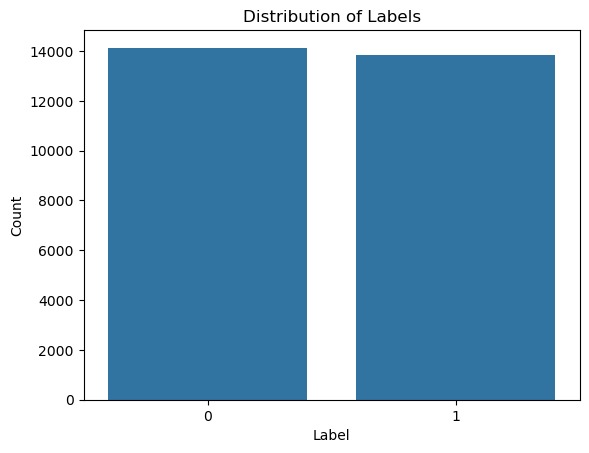

In [32]:

# Ploting the distribution of labels
sns.countplot(x='label', data=mental)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


### Word cloud for  non-poisonous text

Word Cloud for Non-Poisonous Texts (Label 0):


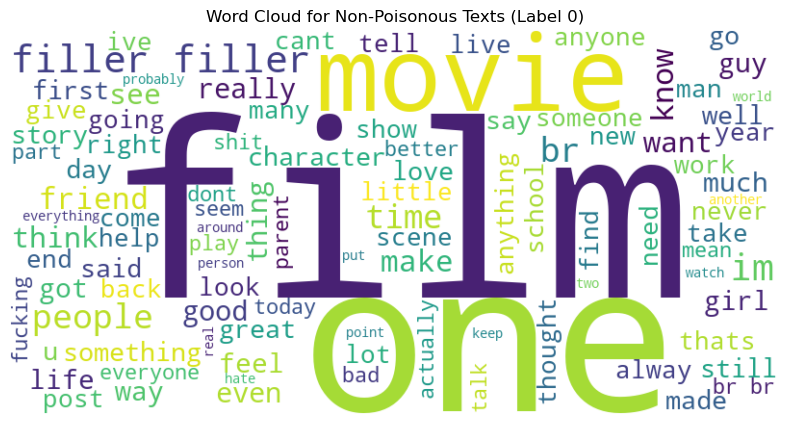

In [33]:

# Function to create and display a word cloud
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot word cloud for non-poisonous texts (Label 0)
print("Word Cloud for Non-Poisonous Texts (Label 0):")
plot_word_cloud(mental[mental['label'] == 0]['text'], 'Word Cloud for Non-Poisonous Texts (Label 0)')


### word cloud for poisonous

Word Cloud for Poisonous Texts (Label 1):


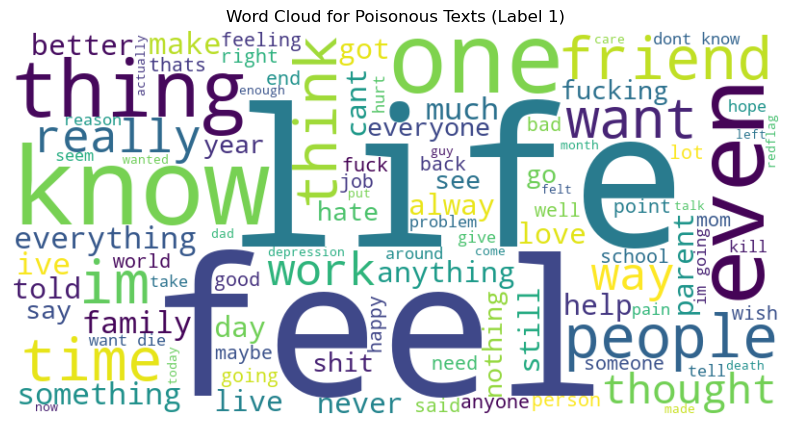

In [34]:
# Plot word cloud for poisonous texts (Label 1)
print("Word Cloud for Poisonous Texts (Label 1):")
plot_word_cloud(mental[mental['label'] == 1]['text'], 'Word Cloud for Poisonous Texts (Label 1)')

## 5) Preprocessing Pipeline

- Text processing helps to prepare the text data for further analysis or modeling by cleaning it and reducing each word to its base form through stemming or lemmatization.

In [35]:

# Initializing NLP tools
nltk.download('punkt')
nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Ensuring the input is a string
    if not isinstance(text, str):
        text = str(text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Lowercase
    tokens = [token.lower() for token in tokens]
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Apply stemming
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)  # Ensure return is a string

# Ensuring the 'text' column is treated as strings
mental['text'] = mental['text'].astype(str)

# Preprocess text data
mental['text'] = mental['text'].apply(preprocess_text)

# Separate texts by label
text_non_poisonous = ' '.join(mental[mental['label'] == 0]['text'])
text_poisonous = ' '.join(mental[mental['label'] == 1]['text'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


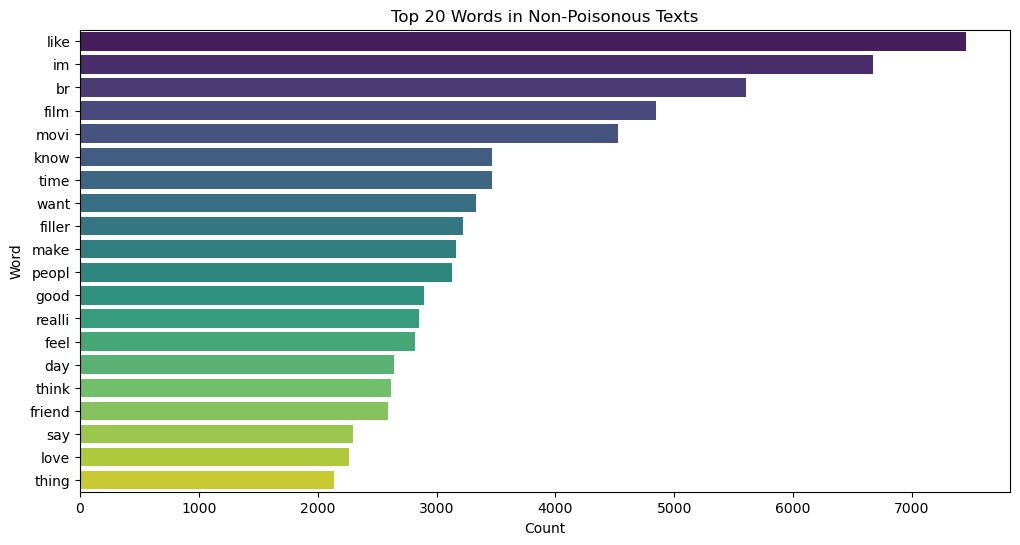

In [36]:
# Function to get top N words

def get_top_n_words(text, n=20):
    vec = CountVectorizer(stop_words='english').fit([text])
    bag_of_words = vec.transform([text])
    sum_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(word_freq, columns=['word', 'count']).head(n)

# Get top 20 words for each label
top_words_non_poisonous = get_top_n_words(text_non_poisonous)
top_words_poisonous = get_top_n_words(text_poisonous)

# Plot top words for non-poisonous texts
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=top_words_non_poisonous, palette='viridis')
plt.title('Top 20 Words in Non-Poisonous Texts')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()


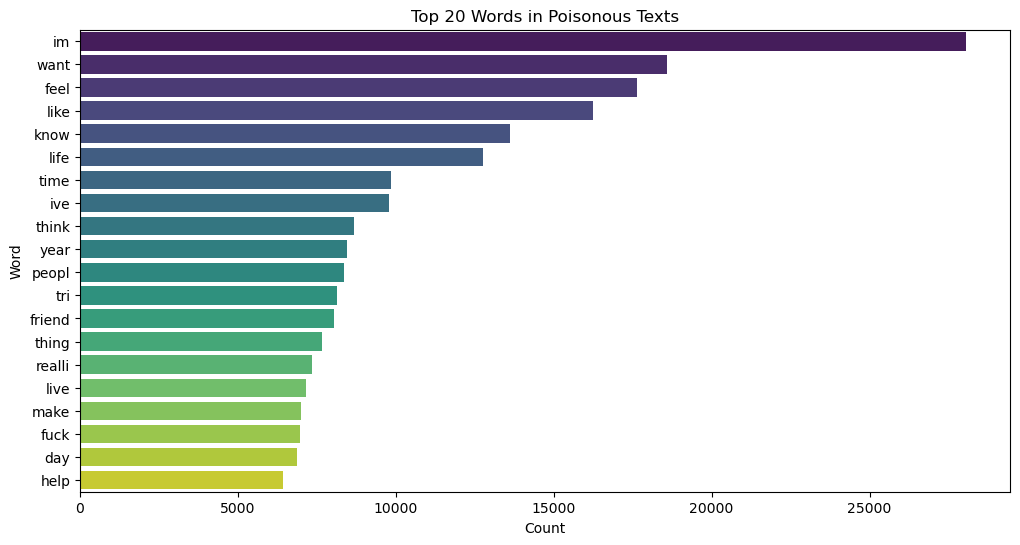

In [37]:
# Plot top words for poisonous texts
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=top_words_poisonous, palette='viridis')
plt.title('Top 20 Words in Poisonous Texts')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

### Handling Class Imbalance using SMOTE

In [39]:

# Define features and target
X = mental['text']
y = mental['label']

# Convert text to numerical features
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print dataset shapes
print(f'Original dataset shape: {pd.Series(y).value_counts()}')
print(f'Resampled dataset shape: {pd.Series(y_resampled).value_counts()}')

Original dataset shape: label
0    14134
1    13838
Name: count, dtype: int64
Resampled dataset shape: label
0    9888
1    9888
Name: count, dtype: int64


## 6) Modelling

### Baseline Model: Logistic Regression

Accuracy: 0.9139656816015252
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      4246
           1       0.92      0.90      0.91      4146

    accuracy                           0.91      8392
   macro avg       0.91      0.91      0.91      8392
weighted avg       0.91      0.91      0.91      8392



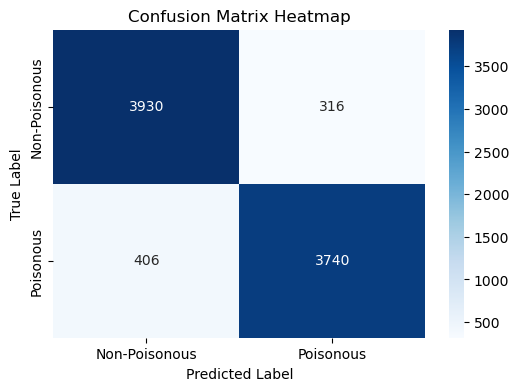

In [45]:
# Train Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualizing the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Poisonous', 'Poisonous'], 
            yticklabels=['Non-Poisonous', 'Poisonous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

- This indicates that the model correctly classified approximately 91.4% of the instances in the test set.
